# Unsupervised pixel-wise segmentation using autoencoder model

This work presents using 1-d convolutional autoencoder model to perform pixel clustering based on raman spectroscopy values.

Things to try:
1. bottleneck size
2. different clustering method
3. visualize single cluster


## 1. Data Preprocessing

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

with h5py.File('MOSAIC_Slices_8 9 10 11 12 13 _PROCESS_same.h5', 'r') as f:
    base_items = list(f.items())
    G1 = f.get('/BCARSImage').get("/BCARSImage/Z97 to 105_58").get("Z97 to 105_58_z13_SubDark_MergeNRBs_Anscombe_SVD_InvAnscombe_KK_PhaseErrorCorrectALS_ScaleErrorCorrectSG_SubtractROI")
    G1_items = np.array(G1)
    print(G1_items.shape)

with h5py.File('MOSAIC_HCMV01_2018925_15_18_27_40030_PROCESS_2018925_16_29_5_508729_(3)_PROCESS_2019122_2_0_59_82982_December_2019.h5', 'r') as f:
    base_items = list(f.items())
    G2 = f.get('/BCARSImage').get('/BCARSImage/AlgaeI_3_5ms_Pos_0_11').get('AlgaeI_3_5ms_Pos_0_11_z16-19_SubDark_Anscombe_SVD_InvAnscombe_MergeNRBs_KK_PhaseErrorCorrectALS_ScaleErrorCorrectSG_Continue_SubtractROI')
    G2_items = np.array(G2)
    print(G2_items.shape)

(420, 556, 1600)
(344, 392, 1600)


In [3]:
data_G1 = (G1_items['Re']**2+G1_items['Im']**2)**0.5
data_G2 = (G2_items['Re']**2+G2_items['Im']**2)**0.5

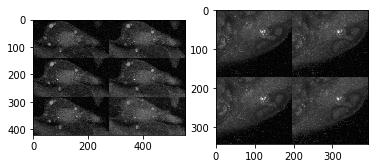

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_G1[:,:,1100], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(data_G2[:,:,1500], cmap='gray')
plt.show()

In [5]:
def crop_image(data, N_H, N_W):

    images = []
    H, W, C = data.shape
    mid_H = H//N_H
    mid_W = W//N_W
    images.append(data[:mid_H, :mid_W, :])
    images.append(data[mid_H:, :mid_W, :])
    images.append(data[:mid_H, mid_W:, :])
    images.append(data[mid_H:, mid_W:, :])

    return images

images_G1 = crop_image(data_G1, 3, 2)
images_G2 = crop_image(data_G2, 2, 2)

In [6]:
# Take the first image
data_G2 = images_G2[0].reshape(np.prod(images_G2[0].shape[:2]), -1)

N = len(data_G2)
train_size = int(np.floor(0.8*N))
indices = np.random.permutation(N)

x_train = data_G2[indices[:train_size], :][:,:,np.newaxis]
x_test = data_G2[indices[train_size:], :][:,:,np.newaxis]

## 2. Autoencoder Structure
### We will start to build 1-d convolutional autoencoder structure

In [7]:
import keras
from keras.layers import Input, Conv1D, MaxPool1D, Flatten, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model

x_input = Input(shape=(1600, 1))
x = Conv1D(16, 3, activation="relu", padding="same")(x_input)
x = MaxPool1D(2, padding="same")(x)
x = Conv1D(8, 3, activation="relu", padding="same")(x)
#x = BatchNormalization()(x)
x = MaxPool1D(2, padding="same")(x)
x = Conv1D(1, 3, activation="relu", padding="same")(x)
#x = BatchNormalization()(x)
encoded = MaxPool1D(2, padding="same")(x)

encoder = Model(x_input, encoded)

x = Conv1D(1, 3, activation="relu", padding="same")(encoded)
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x)
x = Conv1D(8, 2, activation='relu', padding="same")(x)
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding="same")(x)
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
autoencoder = Model(x_input, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# decoded_stocks = autoencoder.predict(x_test)


Using TensorFlow backend.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1600, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1600, 16)          64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 800, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 800, 8)            392       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 400, 8)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 1)            25        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 200, 1)            0   

In [8]:
history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 26969 samples, validate on 6743 samples
Epoch 1/20
26969/26969 [==============================] - 16s 581us/step - loss: 0.6589 - val_loss: 0.6033
Epoch 2/20
26969/26969 [==============================] - 14s 512us/step - loss: 0.5197 - val_loss: 0.4049
Epoch 3/20
26969/26969 [==============================] - 14s 529us/step - loss: 0.2941 - val_loss: 0.1868
Epoch 4/20
26969/26969 [==============================] - 14s 518us/step - loss: 0.1398 - val_loss: 0.1069
Epoch 5/20
26969/26969 [==============================] - 14s 518us/step - loss: 0.0963 - val_loss: 0.0889
Epoch 6/20
26969/26969 [==============================] - 14s 522us/step - loss: 0.0866 - val_loss: 0.0847
Epoch 7/20
26969/26969 [==============================] - 14s 512us/step - loss: 0.0842 - val_loss: 0.0835
Epoch 8/20
26969/26969 [==============================] - 15s 539us/step - loss: 0.0834 - val_loss: 0.0829
Epoch 9/20
26969/26969 [==============================] - 14s 532us/step - loss: 0.0828 - val_l

In [13]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

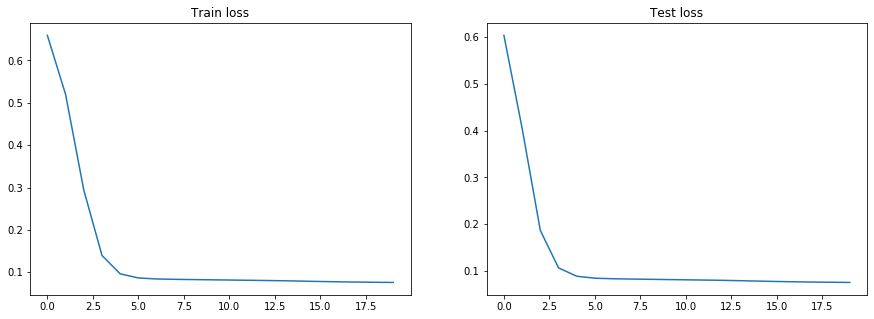

In [14]:
plot_history(history)

In [15]:
feature_extractor = Model(autoencoder.input, autoencoder.get_layer('max_pooling1d_3').output)
features = feature_extractor.predict(data_G2[:,:,np.newaxis])
features = features.squeeze(-1)

## TSNE Non-linear dimensionality reduction

In [20]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(features)
print(X_embedded.shape)

(33712, 2)


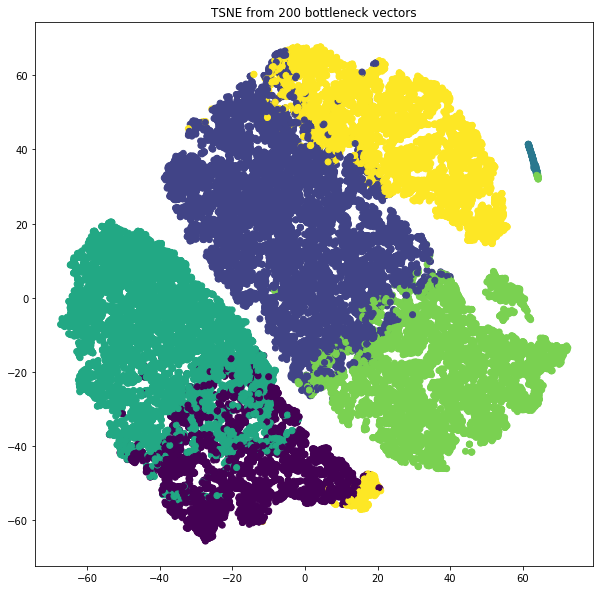

In [29]:
kmeans_model = KMeans(n_clusters=6, random_state=1).fit(features)
labels = kmeans_model.labels_

plt.figure(figsize=(10,10))
plt.title("TSNE from 200 bottleneck vectors")
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)
plt.show()

## K-means clustering on extracted features

0.73284125
0.50200796
0.5020682
0.39238828
0.34002176
0.31559157


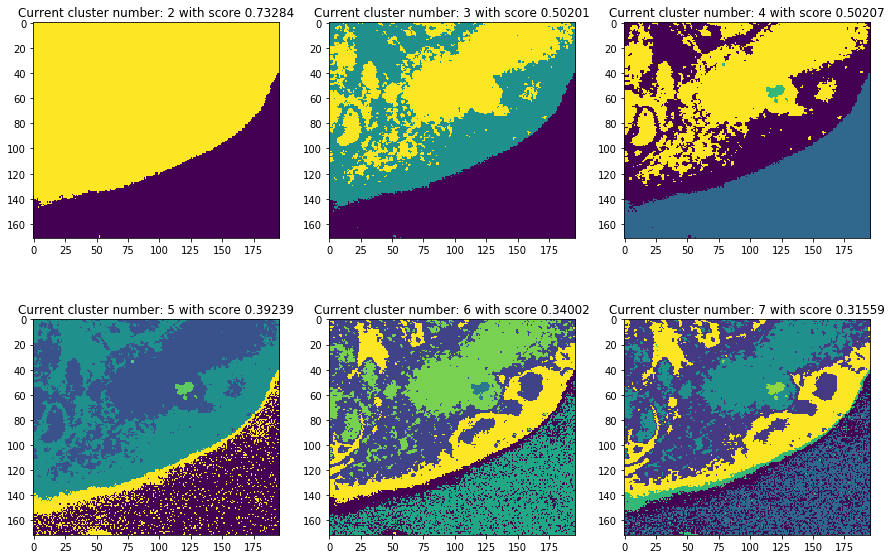

Maximum is number 2, the score is 0.7328412532806396


In [30]:
scores = []
labels_l = []
for i in range(2, 8):

    kmeans_model = KMeans(n_clusters=i, random_state=1).fit(features)
    labels = kmeans_model.labels_

    image_labels = labels.reshape(images_G2[0].shape[0], images_G2[0].shape[1])
    scores_s = metrics.silhouette_score(features, labels, metric='euclidean')
    scores_c = metrics.calinski_harabasz_score(features, labels)
    scores.append(scores_s)
    labels_l.append(image_labels)
    print(scores_s)

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title('Current cluster number: {} with score {:.5f}'.format(i+2, scores[i]))
    plt.imshow(labels_l[i])
plt.show()

print("Maximum is number {}, the score is {}".format(np.argmax(scores)+2, np.max(scores)))

In [51]:
# Spectral Clustering algorithms

from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2).fit(features)
labels = clustering.labels_

image_labels = labels.reshape(images_G2[0].shape[0], images_G2[0].shape[1])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


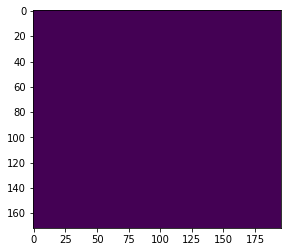

In [53]:
print(image_labels)
plt.imshow(image_labels)
plt.show()